In [ ]:
from enum import IntEnum

import GCode
import GRBL
import matplotlib.pyplot as plt
import numpy as np

# import powersupply
from utils import picture

# Power Consumption Tests

## Object
- Figure out power consumption @ 24V

# Code:

In [1]:
cnc = GRBL.GRBL(port="/dev/cnc_3018")print("Laser Mode: {}".format(cnc.laser_mode))class Tool(IntEnum):    SPINDLE = 0    LASER = 1class LaserPower(IntEnum):    CONSTANT = 0    DYNAMIC = 1LaserPower.CONSTANTdef init(power=LaserPower(0), feed=200, laser=25):    program = GCode.GCode()    program.G21()  # Metric Units    program.G91()  # Absolute positioning.    program.G1(F=feed)  #    if power == LaserPower.CONSTANT:        program.M3(S=laser)  # Laser settings    else:        program.M4(S=laser)  # Laser settings    return programdef end():    program = GCode.GCode()    program.M5()  # Laser settings.    return programdef square(size=20):    program = GCode.GCode()    program.G1(X=size)    program.G1(Y=size)    program.G1(X=-size)    program.G1(Y=-size)    return program

Laser Mode: None


## Test Setup

Power Supply:
- CicuitSpecialists CSI3010SW

Position the paper & other things.

In [4]:
def laser_on(pwm):
    if int(pwm) != np.uint8(pwm):
        raise (Exception("UINT8! {}".format(pwm)))
    # Set minimal power setting to focus and position laser
    cnc.cmd("M3 S{:03d}".format(np.uint8(pwm)))
    cnc.cmd("G1 X0 F10")  # Laser On


def laser_off():
    cnc.cmd("M5")  # Laser off


In [5]:
voltage = (
    24
)  # TODO:# powersupply.voltage(24)current = list()results = list()for laser_pwm in [0, 10, 25, 50, 100, 150, 200, 255]:    result = dict()    result["laser_pwm"] = laser_pwm    result["voltage"] = voltage    laser_on(laser_pwm)    result["current"] = input(        "{}V. PWM: {}. Current Output (A):".format(voltage, laser_pwm)    )    results.append(result)laser_off()results


24V. PWM: 0. Current Output (A):.24
24V. PWM: 10. Current Output (A):.37
24V. PWM: 25. Current Output (A):.50
24V. PWM: 50. Current Output (A):.69
24V. PWM: 100. Current Output (A):.80
24V. PWM: 150. Current Output (A):


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa1 in position 1279: invalid start byte

# Reset!

This is the issue that people are running to online and that I ran into earlier when testing the laser.

Above a certain laser power @ 24V the whole controller resets. This happened at 24V PWM=100. It registered 0.8A for a few seconds then reset.

The device was provided with a 24V Laptop power supply:

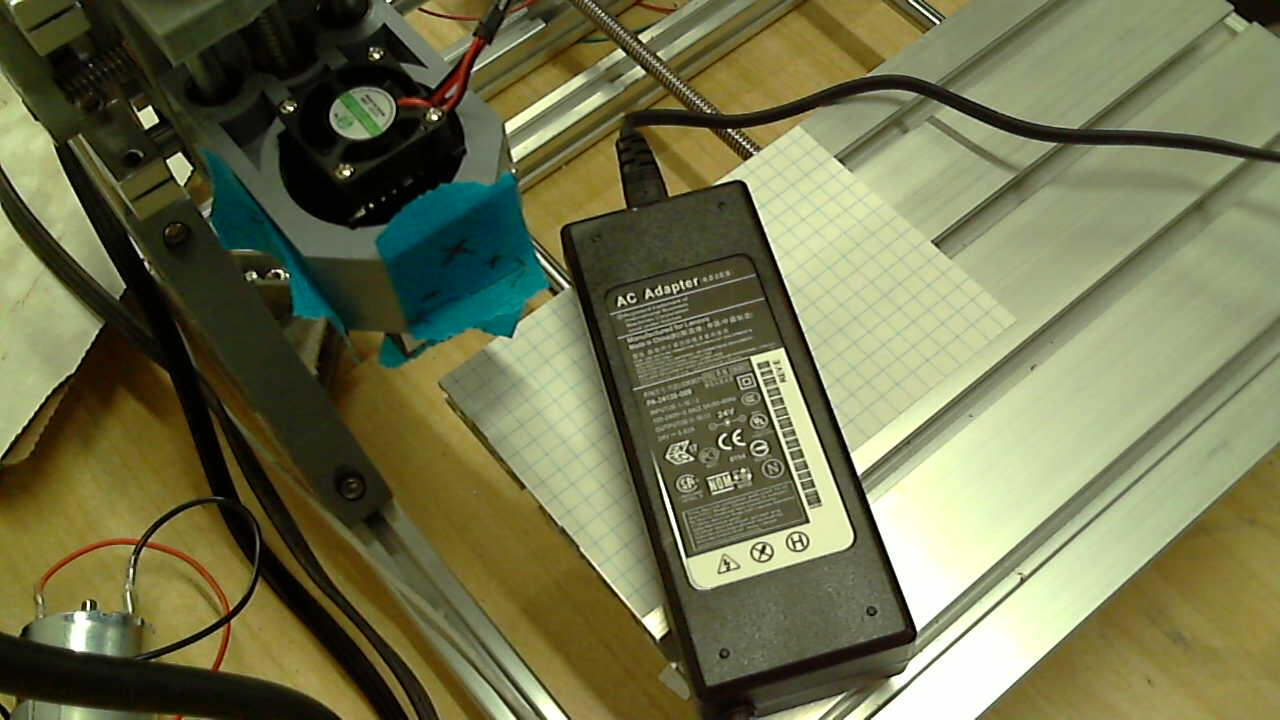

In [10]:
picture()


The laser control board has a 12V in and a TTL port. But only the 12V cord is provided. The "Woodpecker 2.6" control board has a [IRF540NS](http://www.irf.com/product-info/datasheets/data/irf540ns.pdf) power MOSFET.

12V to the "TTL" doesn't let out any magic smoke.

Hooking the "Laser" connector to TTL and 12V to 12V draws a lot of current and melts power cables. But doesn't let any smoke out.

## Run device at 12V for now...